# 5.RNN

## 5.1 概率和语言模型

## 5.2 RNN

## 5.3 RNN的实现

In [1]:
# RNN的实现
# coding: utf-8
from common.np import *  # import numpy as np (or import cupy as np)
from common.layers import *
from common.functions import softmax, sigmoid


class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        t = np.dot(h_prev, Wh) + np.dot(x, Wx) + b
        h_next = np.tanh(t)

        self.cache = (x, h_prev, h_next)
        return h_next

    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache

        dt = dh_next * (1 - h_next ** 2)
        db = np.sum(dt, axis=0)
        dWh = np.dot(h_prev.T, dt)
        dh_prev = np.dot(dt, Wh.T)
        dWx = np.dot(x.T, dt)
        dx = np.dot(dt, Wx.T)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        return dx, dh_prev


class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.dh = None, None
        self.stateful = stateful

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        D, H = Wx.shape

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = RNN(*self.params)
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h
            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D, H = Wx.shape

        dxs = np.empty((N, T, D), dtype='f')
        dh = 0
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh)
            dxs[:, t, :] = dx

            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh

        return dxs

    def set_state(self, h):
        self.h = h

    def reset_state(self):
        self.h = None

## 5.4 处理时序数据的层的实现

In [2]:
# Embedding-time层的实现
class TimeEmbedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.layers = None
        self.W = W

    def forward(self, xs):
        N, T = xs.shape
        V, D = self.W.shape

        out = np.empty((N, T, D), dtype='f')
        self.layers = []

        for t in range(T):
            layer = Embedding(self.W)
            out[:, t, :] = layer.forward(xs[:, t])
            self.layers.append(layer)

        return out

    def backward(self, dout):
        N, T, D = dout.shape

        grad = 0
        for t in range(T):
            layer = self.layers[t]
            layer.backward(dout[:, t, :])
            grad += layer.grads[0]

        self.grads[0][...] = grad
        return None

In [5]:
# Affine-time层的实现
class TimeAffine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None

    def forward(self, x):
        N, T, D = x.shape
        W, b = self.params

        rx = x.reshape(N*T, -1)
        out = np.dot(rx, W) + b
        self.x = x
        return out.reshape(N, T, -1)

    def backward(self, dout):
        x = self.x
        N, T, D = x.shape
        W, b = self.params

        dout = dout.reshape(N*T, -1)
        rx = x.reshape(N*T, -1)

        db = np.sum(dout, axis=0)
        dW = np.dot(rx.T, dout)
        dx = np.dot(dout, W.T)
        dx = dx.reshape(*x.shape)

        self.grads[0][...] = dW
        self.grads[1][...] = db

        return dx

In [6]:
# SoftmaxWithLoss-time层的实现
class TimeSoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None
        self.ignore_label = -1

    def forward(self, xs, ts):
        N, T, V = xs.shape

        if ts.ndim == 3:  # 在监督标签为one-hot向量的情况下
            ts = ts.argmax(axis=2)

        mask = (ts != self.ignore_label)

        # 按批次大小和时序大小进行整理（reshape）
        xs = xs.reshape(N * T, V)
        ts = ts.reshape(N * T)
        mask = mask.reshape(N * T)

        ys = softmax(xs)
        ls = np.log(ys[np.arange(N * T), ts])
        ls *= mask  # 与ignore_label相应的数据将损失设为0
        loss = -np.sum(ls)
        loss /= mask.sum()

        self.cache = (ts, ys, mask, (N, T, V))
        return loss

    def backward(self, dout=1):
        ts, ys, mask, (N, T, V) = self.cache

        dx = ys
        dx[np.arange(N * T), ts] -= 1
        dx *= dout
        dx /= mask.sum()
        dx *= mask[:, np.newaxis]  # 与ignore_label相应的数据将梯度设为0

        dx = dx.reshape((N, T, V))

        return dx

In [7]:
# Dropout-time层的实现
class TimeDropout:
    def __init__(self, dropout_ratio=0.5):
        self.params, self.grads = [], []
        self.dropout_ratio = dropout_ratio
        self.mask = None
        self.train_flg = True

    def forward(self, xs):
        if self.train_flg:
            flg = np.random.rand(*xs.shape) > self.dropout_ratio
            scale = 1 / (1.0 - self.dropout_ratio)
            self.mask = flg.astype(np.float32) * scale

            return xs * self.mask
        else:
            return xs

    def backward(self, dout):
        return dout * self.mask

## 5.5 RNNLM的学习和评价

In [9]:
# RNNLM的学习和评价
import numpy as np

class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        # 初始化权重
        embed_W = (rn(V, D) / 100).astype('f')
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f')
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        # 生成层
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]
        
        # 将所有的权重和梯度整理到列表中
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
        
        def forward(self, xs, ts):
            for layer in self.layers:
                xs = layer.forward(xs)
            loss = self.loss_layer.forward(xs, ts)
            return loss
        
        def backward(self, dout=1):
            dout = self.loss_layer.backward(dout)
            for layer in reversed(self.layers):
                dout = layer.backward(dout)
            return dout
        
        def reset_state(self):
            self.rnn_layer.reset_state()

corpus size: 1000, vocabulary size: 418
| epoch 1 | perplexity 393.63
| epoch 2 | perplexity 256.70
| epoch 3 | perplexity 221.27
| epoch 4 | perplexity 214.60
| epoch 5 | perplexity 205.39
| epoch 6 | perplexity 202.21
| epoch 7 | perplexity 198.56
| epoch 8 | perplexity 197.18
| epoch 9 | perplexity 191.94
| epoch 10 | perplexity 193.03
| epoch 11 | perplexity 189.29
| epoch 12 | perplexity 193.38
| epoch 13 | perplexity 190.31
| epoch 14 | perplexity 190.57
| epoch 15 | perplexity 190.13
| epoch 16 | perplexity 186.23
| epoch 17 | perplexity 184.38
| epoch 18 | perplexity 180.46
| epoch 19 | perplexity 181.48
| epoch 20 | perplexity 183.31
| epoch 21 | perplexity 180.91
| epoch 22 | perplexity 175.76
| epoch 23 | perplexity 173.50
| epoch 24 | perplexity 176.51
| epoch 25 | perplexity 171.04
| epoch 26 | perplexity 172.85
| epoch 27 | perplexity 166.42
| epoch 28 | perplexity 164.82
| epoch 29 | perplexity 159.31
| epoch 30 | perplexity 154.34
| epoch 31 | perplexity 155.45
| epoch 

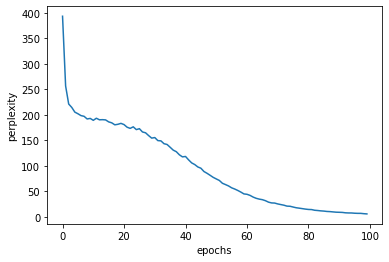

In [11]:
# 语言模型的评价
#RNNLM的学习代码
# coding: utf-8
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
from common.optimizer import SGD
from dataset import ptb
from ch05.simple_rnnlm import SimpleRnnlm


# 设定超参数
batch_size = 10
wordvec_size = 100
hidden_size = 100
time_size = 5  # Truncated BPTT的时间跨度大小
lr = 0.1
max_epoch = 100

# 读入训练数据（缩小了数据集）
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1]  # 输入
ts = corpus[1:]  # 输出（监督标签）
data_size = len(xs)
print('corpus size: %d, vocabulary size: %d' % (corpus_size, vocab_size))

# 学习用的参数
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

# 生成模型
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

# 计算读入mini-batch的各笔样本数据的开始位置
jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

for epoch in range(max_epoch):
    for iter in range(max_iters):
        # 获取mini-batch
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1

        # 计算梯度，更新参数
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1

    # 各个epoch的困惑度评价
    ppl = np.exp(total_loss / loss_count)
    print('| epoch %d | perplexity %.2f'
          % (epoch+1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0

# 绘制图形
x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()

| epoch 1 |  iter 1 / 19 | time 0[s] | perplexity 421.21
| epoch 2 |  iter 1 / 19 | time 0[s] | perplexity 405.87
| epoch 3 |  iter 1 / 19 | time 0[s] | perplexity 294.14
| epoch 4 |  iter 1 / 19 | time 0[s] | perplexity 225.98
| epoch 5 |  iter 1 / 19 | time 0[s] | perplexity 210.59
| epoch 6 |  iter 1 / 19 | time 0[s] | perplexity 208.92
| epoch 7 |  iter 1 / 19 | time 0[s] | perplexity 200.83
| epoch 8 |  iter 1 / 19 | time 0[s] | perplexity 201.27
| epoch 9 |  iter 1 / 19 | time 0[s] | perplexity 196.27
| epoch 10 |  iter 1 / 19 | time 0[s] | perplexity 190.65
| epoch 11 |  iter 1 / 19 | time 0[s] | perplexity 191.66
| epoch 12 |  iter 1 / 19 | time 0[s] | perplexity 189.23
| epoch 13 |  iter 1 / 19 | time 0[s] | perplexity 191.68
| epoch 14 |  iter 1 / 19 | time 0[s] | perplexity 186.58
| epoch 15 |  iter 1 / 19 | time 0[s] | perplexity 185.58
| epoch 16 |  iter 1 / 19 | time 0[s] | perplexity 189.03
| epoch 17 |  iter 1 / 19 | time 0[s] | perplexity 188.45
| epoch 18 |  iter 1 / 

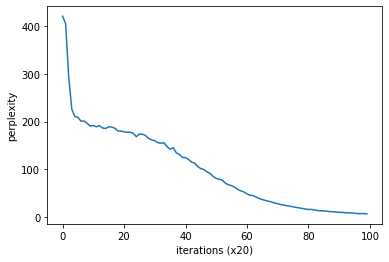

In [12]:
# RNNLM的Trainer类
# coding: utf-8
import sys
sys.path.append('..')
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from dataset import ptb
from ch05.simple_rnnlm import SimpleRnnlm


# 设定超参数
batch_size = 10
wordvec_size = 100
hidden_size = 100  # RNN的隐藏状态向量的元素个数
time_size = 5  # RNN的展开大小
lr = 0.1
max_epoch = 100

# 读入训练数据
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000  # 缩小测试用的数据集
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)
xs = corpus[:-1]  # 输入
ts = corpus[1:]  # 输出（监督标签）

# 生成模型
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

trainer.fit(xs, ts, max_epoch, batch_size, time_size)
trainer.plot()